### 06. 피마 인디언 당뇨병 예측 
피마 인디어 당뇨병 데이터 세트는 북아메리카 피마 지역 원주민의 Type-2 당뇨병 결과 데이터이다.  

* 피처
 * Pregnancies: 임신 횟수
 * Glucose: 포도당 부하 검사 수치
 * Blood Pressure: 혈압(mm Hg)
 * SkinThickness: 팔 삼두근 뒤쪽의 피하지방 측정값(mm)
 * Insulin: 혈청 인슐린(mu U/ml)
 * BMI: 체질량지수(체중(kg)/키(m))^2)
 * DiabetesPedigreeFunction: 당뇨 내력 가중치 값
 * Age: 나이
 * Outcome: 클래스 결정 값(0 또는 1)
 

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.linear_model import LogisticRegression

diabetes_data = pd.read_csv('diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


Negative 값이 상대적으로 많다.

In [15]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Null 값은 없고 피처의 타입은 모두 숫자형이다. 별도의 피처 인코딩은 필요하지 않아 보인다.

In [46]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}.\F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [47]:
# 피처 데이터 세트 X, 레이블 데이터 세트 y를 추출
# 맨 끝이 Outcome 칼럼으로 레이블 값임 
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156, stratify=y)
# original dataset에서 특정 클래스 비율이 불균형한 경우 stratify 매개변수에 타깃 데이터를 지정하여 호출하면 이 비율이 유지될 수 있도록 샘플링한다. 

In [48]:
# 로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[88 12]
 [23 31]]
정확도: 0.7727, 정밀도: 0.7209, 재현율: 0.5741.\F1: 0.6392, AUC:0.7919


C:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


예측 정확도가 77.27%, 재현율이 57.41%로 측정됐다. 전체 데이터의 65%가 Negative 이므로 정확도보다는 재현율 성능에 조금 더 초점을 맞춰 보겠다. 먼저 정밀도 재현율 곡선을 보고 임곗값별 정밀도와 재현율 값의 변화를 확인하겠다. 이를 위해 precision_recall_curve_plot() 함수를 이용하겠다.

In [49]:
def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행, 정밀도는 점선으로 표시
    plt.figure(figsize=(8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    # threshold 값 X축의 scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    # X, Y축 label과 legend, grid 설정
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()

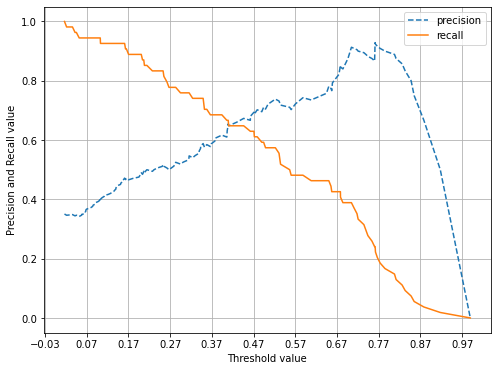

In [37]:
pred_proba_c1 = lr_clf.predict_proba(X_test)[:, 1]
precision_recall_curve_plot(y_test, pred_proba_c1)

재현율 곡선을 보면 임곗값을 0.42 정도로 낮추면 정밀도와 재현율이 어느 정도 균형을 맞출 것 같다. 하지만 두 개의 지표 모두 0.7이 안 되는 수치로 보인다. 여전히 두 지표의 값이 낮다. 임곗값을 인위적으로 조작하기 전에 다시 데이터 값을 점검하겠다. 먼저 원본 데이터 DataFrame의 describe() 메서드를 호출해 피처 값의 분포도를 살펴보겠다.


In [38]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


min() 값이 0으로 되어있는 피처가 상당히 많다. 예를 들어 Glucose 피처는 포도당 수치인데 min 값이 0인 것은 말이 되지 않다. Glucose 히처의 히스토그램을 확인해보면 0 값이 일정 수준 존재하는 것을 알 수 있다.

(array([  5.,   0.,   4.,  32., 156., 211., 163.,  95.,  56.,  46.]),
 array([  0. ,  19.9,  39.8,  59.7,  79.6,  99.5, 119.4, 139.3, 159.2,
        179.1, 199. ]),
 <BarContainer object of 10 artists>)

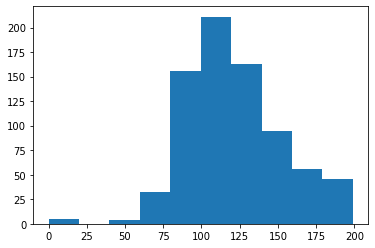

In [39]:
plt.hist(diabetes_data.Glucose, bins=10)

min() 값이 0으로 되어 있는 피처에 대해 0값의 건수 및 전체 데이터 건수 대비 몇 퍼센트의 비율로 존재하는지 확인해 보겠다. 확인할 피처는 Glucose, BloodPressure, SkinThickness, Insulin, BMI이다. 

In [50]:
# 0값을 검사할 피처 명 리스트
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# 전체 데이터 건수
total_count = diabetes_data.Glucose.count()

# 피처별로 반복하면서 데이터 값이 0인 데이터 건수를 추출하고, 퍼센트 계산 
for feature in zero_features:
    zero_count = diabetes_data[diabetes_data[feature] == 0][feature].count()
    print('{0}: 0 건수는 {1}, 퍼센트는 {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

Glucose: 0 건수는 5, 퍼센트는 0.65 %
BloodPressure: 0 건수는 35, 퍼센트는 4.56 %
SkinThickness: 0 건수는 227, 퍼센트는 29.56 %
Insulin: 0 건수는 374, 퍼센트는 48.70 %
BMI: 0 건수는 11, 퍼센트는 1.43 %


SkinThickness와 Insulin의 0 값은 각각 전체의 29.56%, 48.7%로 대단히 많다. 전체 데이터 건수가 많지 않기 때문에 이들 데이터를 일괄적으로 삭제할 경우 학습을 효과적으로 수행하기 어려울 것 같다. 위 피처의 0값을 평균값으로 대체하겠다.

In [51]:
# zero_features 리스트 내부에 저장된 개별 피처들에 대해서 0값을 평균 값으로 대체
mean_zero_features = diabetes_data[zero_features].mean()
diabetes_data[zero_features] = diabetes_data[zero_features].replace(0, mean_zero_features)

0값을 평균값으로 대체한 데이터 세트에 피처 스케일링을 적용해 변환하겠다. 로지스틱 회귀의 경우 일반적으로 숫자 데이터에 스케일링을 적용하는 것이 좋다. 이후에 다시 학습/테스트 데이터 세트로 나누고 로지스틱 회귀를 적용해 성능 평가 지표를 확인하겠다.

In [52]:
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

# StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=156, stratify=y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111.\F1: 0.6804, AUC:0.8433


데이터 변환과 스케일링을 통해 성능 수치가 일정 수준 개선됐다. 하지만 여전히 재현율 수치는 개선이 필요해 보인다. 분류 결정 임곗값을 변화시키면서 재현율 값의 성능 수치가 어느 정도나 개선되는지 확인해보겠다. 다음 코드는 임곗값을 0.3에서 0.5까지 0.03씩 변화시키면서 재현율과 다른 평가 지표의 값 변화를 출력한다. 임곗값에 따른 수치 출력은 앞에서 사용한 get_eval_by_threshold() 함수를 이용한다.

In [53]:
# get_eval_by_threshold()
def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # thresholds list 객체 내의 값을 차례로 iteration하면서 evaluation 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print(f'임곗값: {custom_threshold}')
        get_clf_eval(y_test, custom_predict)

In [55]:
thresholds = [0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임곗값: 0.3


C:\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

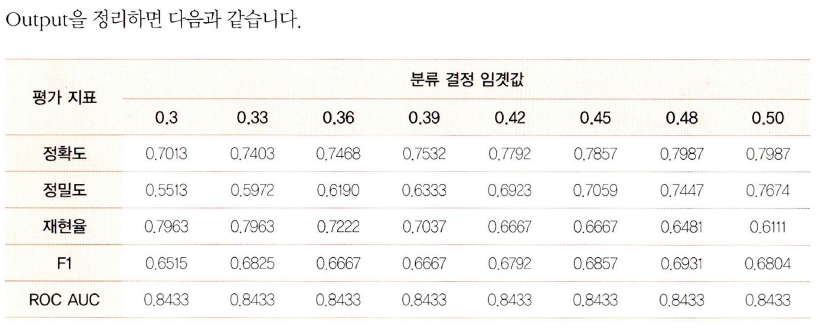
위 표를 근거로 하면 정확도와 정밀도를 희생하고 재현율을 높이는 데 가장 좋은 임계값은 0.33으로, 재현율 값이 0.7963이다. 하지만 정밀도가 0.5972로 매우 저조해졌으니 극단적인 선택으로 보인다. 임계값 0.48이 전체적인 성능 평가 지표를 유지하면서 재현율을 약간 향상시키는 좋은 임계값으로 보인다.     

앞에서 학습된 로지스틱 회귀 모델을 이용해 임계값을 0.48로 낮춘 상태에서 다시 예측을 해보겠다. 사이킷런의 predict() 메서드는 임계값을 마음대로 변환할 수 없으므로 별도의 로직으로 이를 구해야한다. 앞에서 살펴본 Binarizer 클래스를 이용해 predict_proba()로 추출한 예측 결과 확률 값을 변환해 변경된 임계값에 따른 예측 클래스 값을 구해 보겠다.

In [56]:
# 임계값을 0.48로 설정한 Binarizer 생성
binarizer = Binarizer(threshold=0.48)

# 위에서 구한 lr_clf의 predict_proba() 예측 확률 array에서 1에 해당하는 칼럼값을 Binarizer 변환
pred_th_048 = binarizer.fit_transform(pred_proba[:, 1].reshape(-1, 1))

get_clf_eval(y_test, pred_th_048, pred_proba[:, 1])

오차 행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481.\F1: 0.6931, AUC:0.8433
